<a href="https://colab.research.google.com/github/BrenoBaronte/RNNs-for-stock-market-prediction/blob/master/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
label = "H60SMAEC16GC"

In [ ]:
training_file_name = ""
training_file_id = ""
test_file_name = ""
test_file_id = ""

labelInitial = label[0:1]

if (labelInitial == 'H'):
  training_file_name = "dataset_daily_msft_half_training.csv"
  training_file_id = "1Z5uVzXZlomQ5Z-_q-X60upKSUpm724K7"
  test_file_name = "dataset_daily_msft_half_test.csv"
  test_file_id = "15iacoJgstQA0JR0awd0qnhguEu0Lc9zE"

elif (labelInitial == 'T'):
  training_file_name = "dataset_daily_msft_training.csv"
  training_file_id = "12bWmhsQoeAOk2JLCOzlRsk0IMQaKD6s2"
  test_file_name = "dataset_daily_msft_test.csv"
  test_file_id = "10oiV6jvHGtiXgDDJmMByxBhiyYKjaQCw"

else:
  raise Exception("[labelInitial] Invalid argument.")

print(training_file_name)
print(training_file_id)
print(test_file_name)
print(test_file_id)

dataset_daily_msft_half_training.csv
1Z5uVzXZlomQ5Z-_q-X60upKSUpm724K7
dataset_daily_msft_half_test.csv
15iacoJgstQA0JR0awd0qnhguEu0Lc9zE


In [ ]:

 # Step 0 - importing the dataset file
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': training_file_id})
downloaded.GetContentFile(training_file_name)

In [ ]:
# Decode label for entire dataset - T initial

try:
    def labelHasCorrectLength(label):
        if (len(label) == 12):
            return True
        else:
            return False

    def labelHasCorrectInitial(code):
        if (code == 'H' or code == 'T'):
            return True
        else:
            return False        

    def getDaysToLookBack(code):
        if (code == '30'):
            return 30
        if (code == '60'):
            return 60
        else:
            raise Exception("[GetDaysToLookBack] Invalid argument.")

    def getOptimizerAlgorithm(code):
        if (code == 'A' or code == 'a'):
            return 'adam'
        if (code == 'S' or code == 's'):
            return 'SGD'
        else:
            raise Exception("[GetOptimizerAlgorithm] Invalid argument.")

    def getLossAlgorithm(code):
        if (code == 'MSE' or code == 'mse'):
            return 'mean_squared_error'
        if (code == 'MAE' or code == 'mae'):
            return 'mean_absolute_error'
        else:
            raise Exception("[GetLossAlgorithm] Invalid argument.")

    def getEpochs(code):
        if (code == 'L' or code == 'l'):
            return 50
        if (code == 'C' or code == 'c'):
            return 100
        else:
            raise Exception("[GetEpochs] Invalid argument.")

    def getBatchSize(code):
        if (code == '16' or code == '32' or code == '64'):
            return code
        else:
            raise Exception("[GetBatchSize] Invalid argument.")

    def getLayers(code):
        if (code == '5C' or 
            code == '6C' or 
            code == '9C' or 
            code == 'XC' or 
            code == 'GC'):
            return code
        else:
            raise Exception("[GetLayers] Invalid argument.")

    if (labelHasCorrectLength(label) == False):
        raise Exception("[Label length] Invalid argument.")
    
    if (labelHasCorrectInitial(label[0:1]) == False):
        raise Exception("[Label initial] Invalid argument.")
    
    days_to_look_back = int(getDaysToLookBack(label[1:3]))
    optimizer_alg = getOptimizerAlgorithm(label[3:4])
    loss_alg = getLossAlgorithm(label[4:7])
    epochs_to_train = int(getEpochs(label[7:8]))
    batch_size_of_train = int(getBatchSize(label[8:10]))
    network_layers = getLayers(label[10:12])

    print("d t l b: ", days_to_look_back)
    print("o alg: ", optimizer_alg)
    print("l alg: ", loss_alg)
    print("e: ", epochs_to_train)
    print("b s o t: ", batch_size_of_train)
    print("n l: ", network_layers)
    
except e:
    print(e)

d t l b:  60
o alg:  SGD
l alg:  mean_absolute_error
e:  100
b s o t:  16
n l:  GC


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset_train = pd.read_csv(training_file_name)
training_set = dataset_train.iloc[:, 1:2].values

In [ ]:
dataset_train.head()

,timestamp,open,high,low,close,volume
0,2015-06-19,46.79,46.825,45.9900,46.100,63837036
1,2015-06-18,46.22,46.800,46.1700,46.720,32658343
2,2015-06-17,45.73,46.070,45.3600,45.970,28704061
3,2015-06-16,45.35,46.240,45.3000,45.830,27070306
4,2015-06-15,45.45,45.650,45.0201,45.475,33254517


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
training_set_scaled.shape

(1656, 1)

In [ ]:
training_dataset_lines_count = training_set_scaled.shape[0]

In [ ]:
X_train = []
y_train = []
for i in range(days_to_look_back, training_dataset_lines_count):
    X_train.append(training_set_scaled[i-days_to_look_back:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU

In [ ]:
def createModel(code):
    if (code == '5C'):
        regressor = Sequential()

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50))
        regressor.add(Dropout(0.2))

        regressor.add(Dense(units = 1))

        return regressor

    if (code == '6C'):
        regressor = Sequential()

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50))
        regressor.add(Dropout(0.2))

        regressor.add(Dense(units = 25))
        regressor.add(Dense(units = 1))

        return regressor

    if (code == '9C'):
        regressor = Sequential()

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50))
        regressor.add(Dropout(0.2))

        regressor.add(Dense(units = 1))

        return regressor

    if (code == 'XC'):
        regressor = Sequential()

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50))
        regressor.add(Dropout(0.2))

        regressor.add(Dense(units = 25))
        regressor.add(Dense(units = 1))

        return regressor

    if (code == 'GC'):
        regressor = Sequential()

        regressor.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(GRU(units = 50))
        regressor.add(Dropout(0.2))

        regressor.add(Dense(units = 1))

        return regressor

    else:
        raise Exception("[CreateModel] Invalid argument")

In [ ]:
regressor = createModel(network_layers)

In [ ]:
regressor.compile(optimizer = optimizer_alg, loss = loss_alg)

In [ ]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 60, 50)            7950      
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_9 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from time import time
startTime = time()

In [ ]:
history = regressor.fit(X_train, y_train, epochs = epochs_to_train, batch_size = batch_size_of_train)

Epoch 1/100
100/100 [==============================] - 17s 101ms/step - loss: 0.1878
Epoch 2/100
100/100 [==============================] - 10s 100ms/step - loss: 0.0767
Epoch 3/100
100/100 [==============================] - 8s 81ms/step - loss: 0.0422
Epoch 4/100
100/100 [==============================] - 5s 54ms/step - loss: 0.0389
Epoch 5/100
100/100 [==============================] - 5s 54ms/step - loss: 0.0367
Epoch 6/100
100/100 [==============================] - 5s 53ms/step - loss: 0.0344
Epoch 7/100
100/100 [==============================] - 5s 52ms/step - loss: 0.0341
Epoch 8/100
100/100 [==============================] - 5s 53ms/step - loss: 0.0357
Epoch 9/100
100/100 [==============================] - 5s 53ms/step - loss: 0.0354
Epoch 10/100
100/100 [==============================] - 5s 54ms/step - loss: 0.0314
Epoch 11/100
100/100 [==============================] - 5s 54ms/step - loss: 0.0315
Epoch 12/100
100/100 [==============================] - 5s 55ms/step - loss: 0.03

In [ ]:
trainingTimeInSeconds = time() - startTime
trainingTimeInSeconds

563.6356246471405

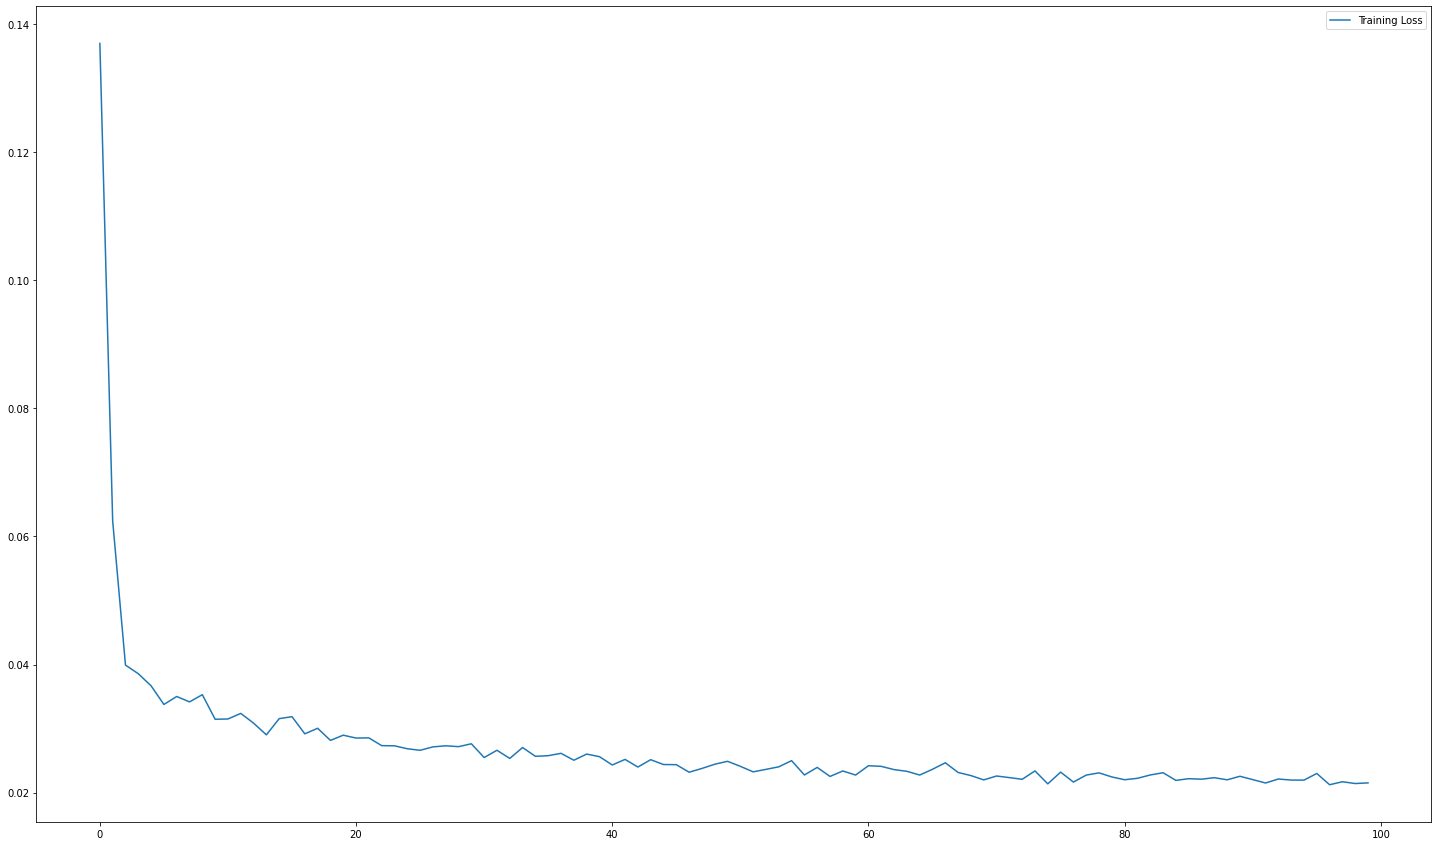

In [ ]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.legend()
plt.show()

In [ ]:
last_loss = history.history["loss"][-1]
last_loss

0.021528111770749092

In [ ]:
#getting test data

downloaded = drive.CreateFile({'id': test_file_id})
downloaded.GetContentFile(test_file_name)

In [ ]:
dataset_test = pd.read_csv(test_file_name)
real_stock_price = dataset_test.iloc[:, 1:2].values

In [ ]:
dataset_test.shape

(890, 6)

In [ ]:
dataset_test.head()

,timestamp,open,high,low,close,volume
0,2019-01-02,99.55,101.75,98.94,101.12,35329345
1,2018-12-31,101.29,102.40,100.44,101.57,33173765
2,2018-12-28,102.09,102.41,99.52,100.39,38169312
3,2018-12-27,99.30,101.19,96.40,101.18,49498509
4,2018-12-26,95.14,100.69,93.96,100.56,51634793


In [ ]:
test_dataset_lines_count = dataset_test.shape[0]

In [ ]:
dataset_total = pd.concat((dataset_train['open'], dataset_test['open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - days_to_look_back:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(days_to_look_back, test_dataset_lines_count + days_to_look_back): # 1909 is dataset_test x shape + 60, this 60 is days to look back
    X_test.append(inputs[i-days_to_look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
test_loss = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
test_loss

5.293485058499481

In [ ]:
plt.rcParams['figure.figsize'] = (25,15)

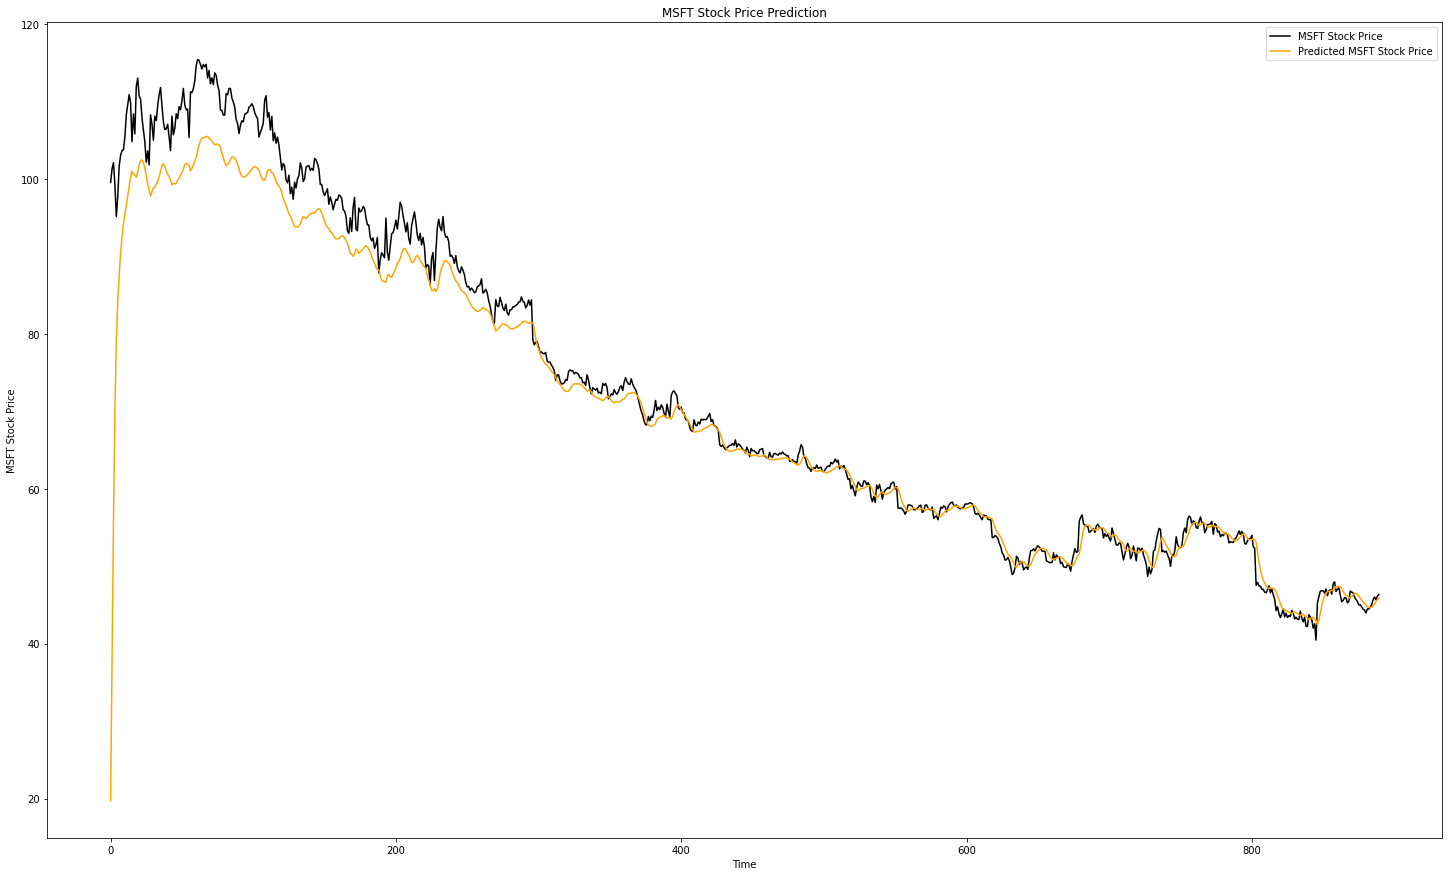

In [ ]:
plt.plot(real_stock_price, color = 'black', label = 'MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'orange', label = 'Predicted MSFT Stock Price', linestyle = 'solid')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()

In [ ]:
"time: " + str(trainingTimeInSeconds).replace(".", ",") + " |  test_loss: " + str(test_loss).replace(".", ",") + " | training_loss: " + str(last_loss).replace(".", ",")

'time: 563,6356246471405 |  test_loss: 5,293485058499481 | training_loss: 0,021528111770749092'